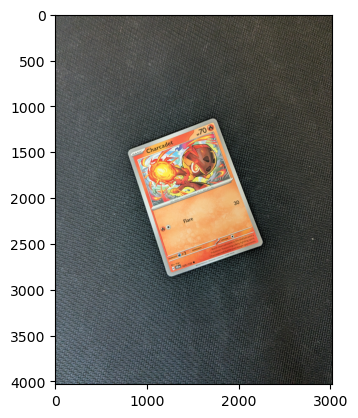

In [234]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image = cv2.imread('test_images/tiltleft.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)


In [235]:
video = cv2.VideoCapture(0)
_, frame = video.read()
video.release()

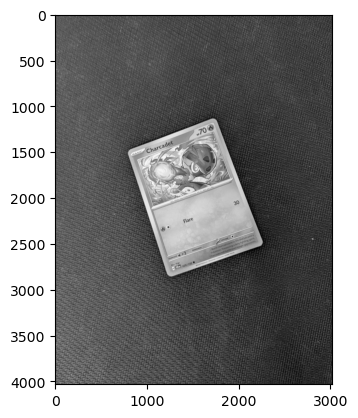

In [236]:
# Step 2: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(src=gray, ksize=(9, 9), sigmaX=0)
plt.imshow(blurred, cmap="gray")

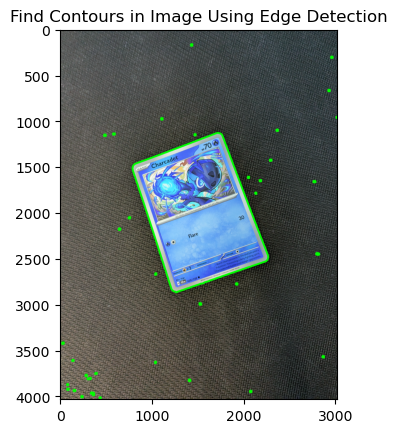

In [237]:
# Step 3: Edge detection
kernel = np.ones(shape=(11, 11))
morph = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)
edges = cv2.Canny(morph, 100, 200)
dilated = cv2.dilate(edges, kernel, iterations=1)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)

contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()
cv2.drawContours(
    image=contour_image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=20
)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
plt.title("Find Contours in Image Using Edge Detection")
plt.imshow(contour_image)

In [238]:
# Step 4: Find contours

best_contour = None
best_approx = None
min_area = image.shape[0] * image.shape[1] * 0.10  # 10% of image area
max_area = image.shape[0] * image.shape[1] * 0.95  # 95% of image area

# Loop through contours to find the largest one with 4 sides
for contour in contours:
    # Approximate the contour
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.1 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
    
        # Check if the approximated contour has 4 vertices
        if len(approx) == 4:
            if best_contour is None or cv2.contourArea(contour) > cv2.contourArea(best_contour):
                best_contour = contour
                best_approx = approx
if best_contour is not None:
    print("Found a 4 Sided Contour")
else:
    print("No 4 Sided Contour Found")

Found a 4 Sided Contour


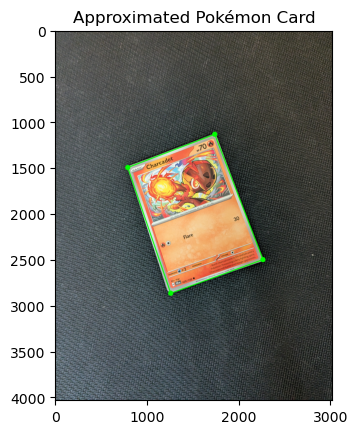

In [239]:
# Step 5: Draw the 4 Sided Card Approximation
if best_contour is not None:
    approx_image = image.copy()
    
    for point in best_approx:
        x, y = point[0]
        cv2.circle(approx_image, (x, y), 3, (0, 255, 0), 50)

    # drawing skewed rectangle
    cv2.drawContours(approx_image, [best_approx], -1, (0, 255, 0), 10)
    
    # Display the image with the contour using Matplotlib
    approx_image_rgb = cv2.cvtColor(approx_image, cv2.COLOR_BGR2RGB)
    plt.imshow(approx_image_rgb)
    plt.title('Approximated Pokémon Card')
    plt.show()

In [240]:
# Step 5: Reorder the corners

# Order needs to be top-left, top-right, bottom-right, bottom-left

corners = np.array(best_approx).reshape(4, 2)

# Calculate the sum of each corner's coordinates along axis 1
coord_sums = corners.sum(axis=1)

# Get the indices that would sort the coordinate sums
sorted_indices = np.argsort(coord_sums)

top_left = corners[sorted_indices[0]]
bottom_right = corners[sorted_indices[3]]

is_titled_right = corners[sorted_indices[1]][1] > corners[sorted_indices[2]][1]
if is_titled_right:
    top_right = corners[sorted_indices[2]]
    bottom_left = corners[sorted_indices[1]]
else:
    top_right = corners[sorted_indices[1]]
    bottom_left = corners[sorted_indices[2]]

ordered_corners = np.array([
    top_left,
    top_right,
    bottom_right,
    bottom_left,
], dtype="float32")

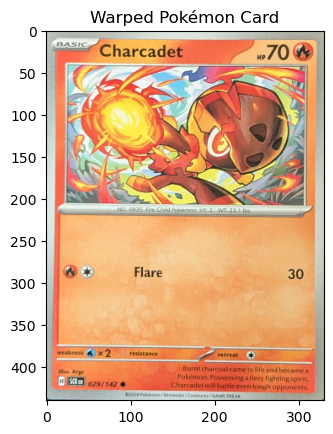

In [241]:
# Step 6: Warp the image to a Rectangle
    
width, height = 330, 440
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')

# Get the perspective transform matrix
M = cv2.getPerspectiveTransform(ordered_corners, dst)
warped = cv2.warpPerspective(image, M, (width, height))

# Convert BGR to RGB for Matplotlib
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Display the result using Matplotlib
plt.imshow(warped_rgb)
plt.title('Warped Pokémon Card')
plt.show()